### 실습 자료중 Minist with DNN이 비슷한 Flow이니까 참고해서 해주시면 됩니다.

In [11]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.15.0'

### 데이터 로드
* TF에서 제공하는 데이터셋을 load해 간단한 전처리 진행

In [12]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.fashion_mnist.load_data()

In [13]:
print(train_data.shape, train_labels.shape)

(60000, 28, 28) (60000,)


In [14]:
train_data, valid_data, train_labels, valid_labels = \
    train_test_split(train_data, train_labels, test_size=0.1, shuffle=True)

In [15]:
print(train_data.shape, train_labels.shape)

(54000, 28, 28) (54000,)


In [16]:
print(valid_data.shape, valid_labels.shape)

(6000, 28, 28) (6000,)


label = 1


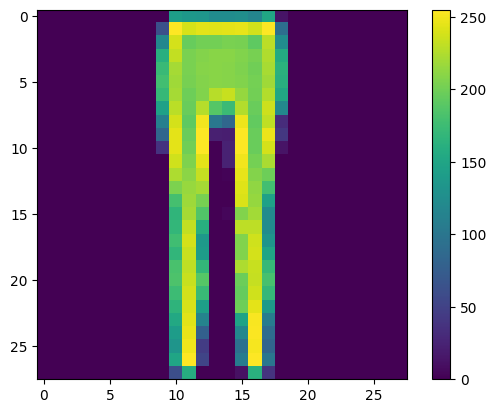

In [17]:
index = 5901
print("label = {}".format(valid_labels[index]))
plt.imshow(valid_data[index].reshape(28, 28))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

In [18]:
train_data = train_data / 255.
train_data = train_data.reshape(-1, 28 * 28)
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data / 255.
test_data = test_data.reshape(-1, 28 * 28)
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

valid_data = valid_data / 255.
valid_data = valid_data.reshape(-1, 28 * 28)
valid_data = valid_data.astype(np.float32)
valid_labels = valid_labels.astype(np.int32)


print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)


(54000, 784) (54000,)
(10000, 784) (10000,)
(6000, 784) (6000,)


### 학습에 사용할 tf.data.Dataset 구성
* 학습에 잘 적용할 수 있도록 label 처리
* 데이터셋 구성



```
# dataset format (dataloader 설정시)
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
```



```
# 실행 결과
<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
```





In [19]:
def one_hot_label(image, label):
  label = tf.one_hot(label, depth=10)
  return image, label

In [22]:
batch_size = 32

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=32)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=100)
print(test_dataset)

# for test
valid_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
valid_dataset = valid_dataset.map(one_hot_label)
valid_dataset = valid_dataset.batch(batch_size=5)
print(valid_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### 모델 구성

- Layer: input Layer: 64 -> 32 -> 16 -> output: 10 Layer


- tf.keras.layers.Dense format
```
 def __init__(self,
               units,
               activation=None,
               use_bias=True,
               kernel_initializer='glorot_uniform',
               bias_initializer='zeros',
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
```



In [26]:
# Flatten (inputs)
# Dense 64 relu
# Dense 32 relu
# Dense 16 relu
# (outputs)

model = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
# without training, just inference a model in eager execution:
predictions = model(train_data[0:1], training=False)
print("Predictions: ", predictions.numpy())

Predictions:  [[0.1663584  0.03310179 0.13281752 0.11432549 0.1000111  0.10827244
  0.02562018 0.17624708 0.09135287 0.05189313]]


In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (1, 64)                   50240     
                                                                 
 dense_8 (Dense)             (1, 64)                   4160      
                                                                 
 dense_9 (Dense)             (1, 64)                   4160      
                                                                 
 dense_10 (Dense)            (1, 10)                   650       
                                                                 
Total params: 59210 (231.29 KB)
Trainable params: 59210 (231.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 모델 학습 구성

In [30]:
check_point_cb = callbacks.ModelCheckpoint('fashion_mnist_model.h5',
                                           save_best_only=True,
                                           verbose=1)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                            monitor='val_loss',
                                            restore_best_weights=True,
                                            verbose=1)

In [35]:
max_epochs = 100
# using `tf.data.Dataset`
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=20,
                    validation_data=valid_dataset,
                    validation_steps=20,
                    callbacks=[check_point_cb, early_stopping_cb]
                   )

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


14/20 [====================>.........] - ETA: 0s - loss: 2.3291 - accuracy: 0.0871
Epoch 1: val_loss improved from inf to 2.22088, saving model to fashion_mnist_model.h5
20/20 [==============================] - 3s 29ms/step - loss: 2.3139 - accuracy: 0.1078 - val_loss: 2.2209 - val_accuracy: 0.1500
Epoch 2/100
14/20 [====================>.........] - ETA: 0s - loss: 2.2120 - accuracy: 0.1942
Epoch 2: val_loss improved from 2.22088 to 2.13933, saving model to fashion_mnist_model.h5
20/20 [==============================] - 0s 8ms/step - loss: 2.1893 - accuracy: 0.2234 - val_loss: 2.1393 - val_accuracy: 0.2000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/100
14/20 [====================>.........] - ETA: 0s - loss: 2.1282 - accuracy: 0.2835
Epoch 3: val_loss improved from 2.13933 to 2.05252, saving model to fashion_mnist_model.h5
20/20 [==============================] - 0s 8ms/step - loss: 2.1052 - accuracy: 0.3203 - val_loss: 2.0525 - val_accuracy: 0.3600
Epoch 4/100
14/20 [====================>.........] - ETA: 0s - loss: 2.0307 - accuracy: 0.3817
Epoch 4: val_loss improved from 2.05252 to 1.95491, saving model to fashion_mnist_model.h5
20/20 [==============================] - 0s 9ms/step - loss: 2.0127 - accuracy: 0.4047 - val_loss: 1.9549 - val_accuracy: 0.4600
Epoch 5/100
14/20 [====================>.........] - ETA: 0s - loss: 1.8872 - accuracy: 0.5000
Epoch 5: val_loss improved from 1.95491 to 1.82658, saving model to fashion_mnist_model.h5
20/20 [==============================] - 0s 8ms/step - loss: 1.8729 - accuracy: 0.5047 - val_loss: 1.8266 - val_accuracy: 0.5600
Epoch 6/100
14/20 [====================>.........] - ET

KeyboardInterrupt: 

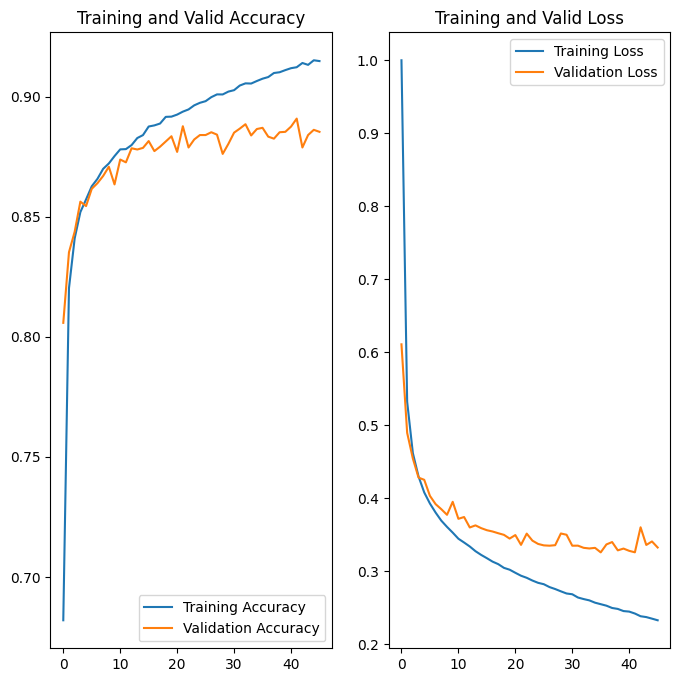

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Valid Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Valid Loss')
plt.show()

In [ ]:
results = model.evaluate(test_dataset)

313/313 [==============================] - 1s 3ms/step - loss: 0.3580 - accuracy: 0.8738
